# Assembly of tracer transport with diffusion 

This notebook will consider advective tracer transport with a diffusive term for a flow field

In [1]:
import numpy as np
import porepy as pp

import scipy.sparse as sps

The below method (inspired by `tutorials > tracer_transport`) is used to assign transport data. (Currently I `assert` that)

##### Some physical notes:
Default is flow to the right.


In [2]:
def assign_data(gb, domain, **kwargs):
    """ Method to assign data for flow-transport problems.
    
    Parameters
    gb (pp.GridBucket): Grid bucket
    domain (dict): Specifies the grid boundaries.
        Assumes it contains the keys: xmin, xmax, ymin, ymax.
    kwargs (dict): Dictionary of grid data to be set. 
        Keywords are as follows:
            frac_perm (float, default: 1e3): permeability in fractures
            matrix_perm (float, default: 1): permeability in matrix
            flowdir (str, default: 'E'): Direction of flow.
                           Valid values: 'N', 'E', 'S', 'W'.
            porosity (float, default: 0.2): Porosity.

    """
    kw_f = 'flow'
    kw_t = 'transport'
    
    frac_perm = kwargs.get('frac_perm',1e3)
    matrix_perm = kwargs.get('matrix_perm', 1)
    flowdir = kwargs.get('flowdir', 'E')
    poro = kwargs.get('porosity', 0.2)
    
    tol = 1e-4
    for g, d in gb:
        
        # Assign permeability for matrix and fractures
        if g.dim == gb.dim_max():
            kxx = matrix_perm * np.ones(g.num_cells)
        else:
            kxx = frac_perm * np.ones(g.num_cells)
        perm = pp.SecondOrderTensor(kxx)
        
        # Boundary conditions
        b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
        bc_val = np.zeros(g.num_faces)
        
        unity = np.ones(g.num_cells)
        empty = np.empty(0)
        if b_faces.size != 0:
            
            b_face_centers = g.face_centers[:, b_faces]
            if flowdir in ['W', 'E']:
                axis = 0
                mi, ma = map(domain.get, ['xmin', 'xmax'])
            else:
                axis = 1
                mi, ma = map(domain.get, ['ymin', 'ymax'])
            
            # flowdir in ['E', 'N']
            b_inflow = b_face_centers[axis, :] < mi + tol
            b_outflow = b_face_centers[axis, :] > ma - tol
            
            if flowdir in ['S', 'W']:
                b_inflow, b_outflow = b_outflow, b_inflow
            
            labels = np.array(['neu'] * b_faces.size)
            labels[np.logical_or(b_inflow, b_outflow)] = "dir"
            bc = pp.BoundaryCondition(g, b_faces, labels)
            
            # Set inflow to 1. (Outflow is 0).
            bc_val[b_faces[b_inflow]] = 4
        
        else:
            bc = pp.BoundaryCondition(g)
        
        # Porosity
        if g.dim == gb.dim_max():
            porosity = poro * unity
            aperture = 1
        else:
            porosity = (1 - poro) * unity
            aperture = np.power(1e-4, gb.dim_max() - g.dim)
        
        # Set parameters for flow and transport.
        specified_parameters = {
            "bc": bc,
            "bc_values": bc_val,
            "time_step": 1 / 60,
            "mass_weight": porosity * aperture,
            "t_max": 1 / 3,
            }
        pp.initialize_default_data(g, d, kw_f, specified_parameters)
        pp.initialize_default_data(g, d, kw_t, specified_parameters)
        
        # Store the dimension in the dictionary for visualization purposes
        d[pp.STATE] = {"dimension": g.dim * np.ones(g.num_cells)}
    
    for e, d in gb.edges():
        data = {"normal_diffusivity": 2e1}
        if pp.PARAMETERS not in d:
            d[pp.PARAMETERS] = pp.Parameters(keywords=['flow_param_edge'], dictionaries=[data])
        else:
            d[pp.PARAMETERS].update_dictionaries(['flow_param_edge'], [data])
        d[pp.PARAMETERS].update_dictionaries([kw_f, kw_t], [{}, {}])
        
        
        # unsure if I need these lines
        if pp.DISCRETIZATION_MATRICES not in d:
            d[pp.DISCRETIZATION_MATRICES] = {}
            
        d[pp.DISCRETIZATION_MATRICES][kw_f] = {}
        d[pp.DISCRETIZATION_MATRICES][kw_t] = {}

    return gb

In [3]:
pp.initialize_default_data(pp.CartGrid([1,1]), {}, 'transport')

{'discretization_matrices': {'transport': {}},
 'parameters': Data object for physical processes transport
 The keyword "transport" has the following parameters specified: source, mass_weight, second_order_tensor, bc, bc_values, darcy_flux, time_step}

In [4]:
pp.initialize_default_data(pp.CartGrid([1,1]), {}, 'flow')

{'discretization_matrices': {'flow': {}},
 'parameters': Data object for physical processes flow
 The keyword "flow" has the following parameters specified: source, mass_weight, second_order_tensor, bc, bc_values, time_step}

## Below:
Define a 2D domain on $[-2,3] \times [-2,3]$.

Define fractures from $(0,0)$ to $(2,0)$, and from $(1,0)$ to $(1,1)$.

Mesh it with mesh parameters:
* `'mesh_size_frac': 0.2`
* `'mesh_size_bound': 0.3`
* `'mesh_size_min': 0.05`

In [6]:
# First, define 2D coordinates of fracture vertices (np.ndarray: 2 x n)
p = np.array([[-1, 2, 1, 1], [0, 0, 0, 1]])
# Connect the endpoints of fracture vertices by an index mapping (np.ndarray: 2 x num_fracs)
e = np.array([[0, 2], [1, 3]])

# Set domain boundaries
domain = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3}

# Deine a fracture network in 2D
network_2d = pp.FractureNetwork2d(p, e, domain)

# Set preferred mesh size near the fracture and at the boundary
mesh_args = {'mesh_size_frac': 0.2, 
             'mesh_size_bound': 0.3,
             'mesh_size_min': 0.05}
#mesh_args = {'mesh_size_frac': 1, 
#             'mesh_size_bound': 1,
#             'mesh_size_min': 1}

# Generate a mixed-dimensional mesh
gb = network_2d.mesh(mesh_args)

In [7]:

# Initially, initialize flow to default values
kw_t = "transport"
kw_f = "flow"
flow_param_edge = 'flow_param_edge'

# Initialize flow and transport variables
gb = assign_data(gb, domain)

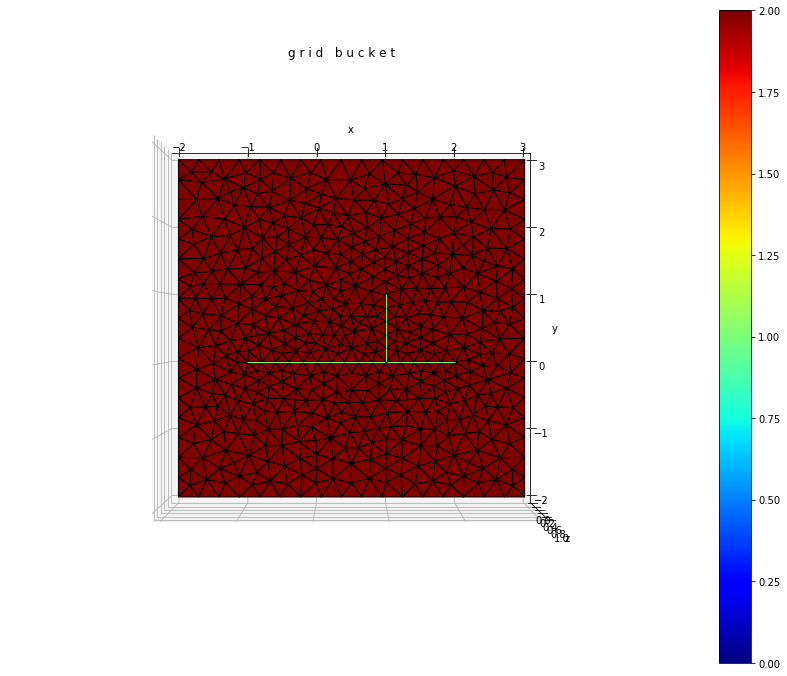

In [8]:
pp.plot_grid(gb, "dimension", figsize=(15, 12))

In [9]:
g2 = gb.grids_of_dimension(2)[0]
data = gb.node_props(g2)
data[pp.PARAMETERS]['flow']['bc']

# First, solve the pressure problem

In [10]:
# Name of variables we want to solve for
grid_variable = 'pressure'
mortar_variable = 'mortar_flux'

# Name of operators we want to use
operator_keyword = 'diffusion'
coupling_operator_keyword = 'coupling_operator'

# We solve diffusion, so tpfa is the correct method:
tpfa = pp.Tpfa(kw_f)

# Set up the coupling for edges
# NOTE!!!: flow_param_edge MUST correspond to a data dict in gb.edges
# where we need: d[pp.PARAMETERS][flow_param_edge][normal_diffusivity] = ...
edge_discretization = pp.RobinCoupling(flow_param_edge, tpfa, tpfa)

# Define primary variables and discretization on each grid in the bucket
for g, d in gb:
    # primary variable is 'pressure'
    # tpfa allows for 1 degree of freedom on cells and 0 degrees on faces.
    d[pp.PRIMARY_VARIABLES] = {grid_variable: {"cells": 1, "faces": 0}}
    
    # For 'pressure', we solve 'diffusion' using tpfa.
    d[pp.DISCRETIZATION] = {grid_variable: {operator_keyword: tpfa}}

for e, d in gb.edges():
    
    # Get the grids connected by the edge (mortar).
    g1, g2 = gb.nodes_of_edge(e)
    
    # Define primary variable ('mortar_flux') on the mortar grid.
    d[pp.PRIMARY_VARIABLES] = {mortar_variable: {"cells": 1}}
    
    # Define the coupling between grids connected by the mortar.
    d[pp.COUPLING_DISCRETIZATION] = {
        coupling_operator_keyword: {
            g1: (grid_variable, operator_keyword),
            g2: (grid_variable, operator_keyword),
            e: (mortar_variable, edge_discretization),
        }
    }
    d[pp.DISCRETIZATION_MATRICES] = {flow_param_edge: {}}

Assemble the system and solve. 

Then, distribute the variables on the grid bucket.

Since fluxes are not the primary variables of the FV scheme we use (tpfa), we need to "back-compute" the fluxes.

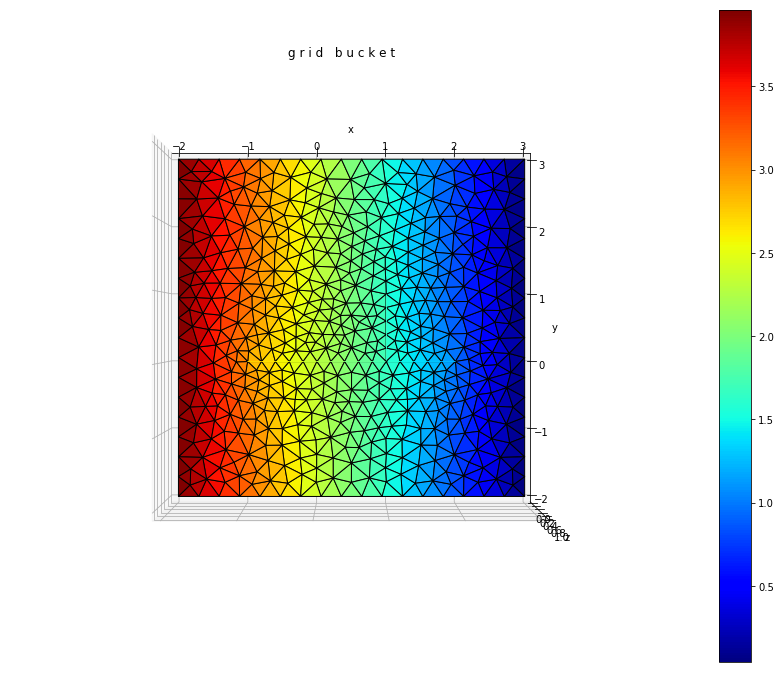

In [11]:
assembler = pp.Assembler(gb)

# Discretize all terms
assembler.discretize()

# Assemble the linear system using the provided information
A, b = assembler.assemble_matrix_rhs()

pressure = sps.linalg.spsolve(A, b)

assembler.distribute_variable(pressure)

pp.fvutils.compute_darcy_flux(gb, keyword_store=kw_t, lam_name=mortar_variable)
pp.plot_grid(gb,grid_variable, figsize=(15,12))

/home/haakon/anaconda3/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:753: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


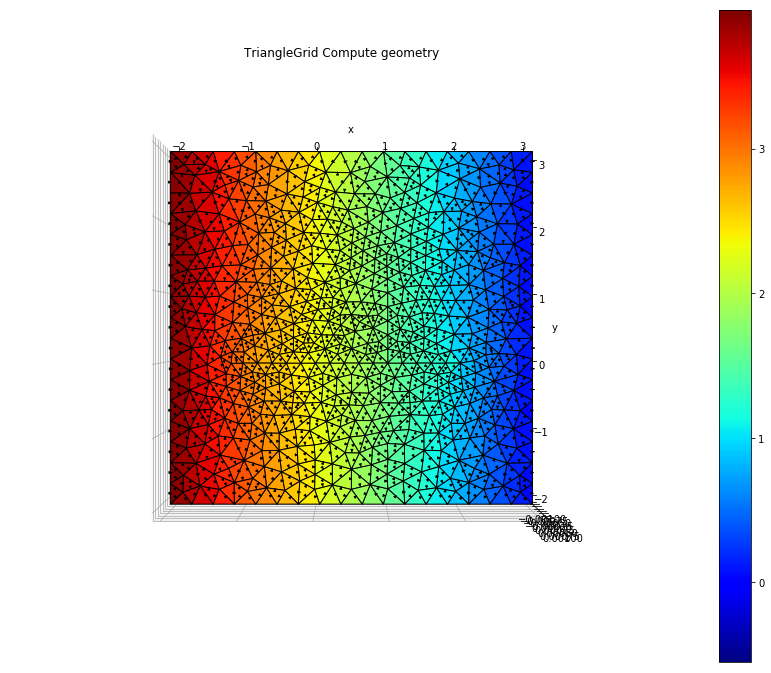

In [12]:
# Compute the darcy flux for the dimension 2 grid.
for g, d in gb:
    if g.dim==2:
        d2 = d
        gr = g
        p0u = d[pp.PARAMETERS]['transport']['darcy_flux'] * g.face_normals
        p = tpfa.extract_pressure(g, pressure, d)
        

d2[pp.STATE]['flux'] = p0u

pp.plot_grid(gr, p,p0u*0.4, figsize=(15,12))

In [13]:
#exporter = pp.Exporter(gr, "testsol", folder="testresults")
#exporter.write_vtk(gr, ['flux'])

## Next, solve transport
First, we prepare assembly for the transport problem. First, following the tutorial `tracer_transport`, only the advective term is added. Following that, we will add the diffusive term.

In [14]:
grid_variable = "tracer"
mortar_variable = "mortar_tracer"

# Identifier of the discretization operator on each grid
advection_term = "advection"
source_term = "source"
mass_term = "mass"

# Identifier of the discretization operator between grids
advection_coupling_term = "advection_coupling"

# Discretization objects
node_discretization = pp.Upwind(kw_t)
source_discretization = pp.ScalarSource(kw_t)
mass_discretization = pp.MassMatrix(kw_t)
edge_discretization = pp.UpwindCoupling(kw_t)

# Loop over the nodes in the GridBucket, define primary variables and discretization schemes
for g, d in gb:
    # Assign primary variables on this grid. It has one degree of freedom per cell.
    d[pp.PRIMARY_VARIABLES] = {grid_variable: {"cells": 1, "faces": 0}}
    # Assign discretization operator for the variable.
    d[pp.DISCRETIZATION] = {
        grid_variable: {
            advection_term: node_discretization,
            source_term: source_discretization,
            mass_term: mass_discretization,
        }
    }
    if g.dim == 2:
        data = d[pp.PARAMETERS][kw_t]

# Loop over the edges in the GridBucket, define primary variables and discretizations
for e, d in gb.edges():
    g1, g2 = gb.nodes_of_edge(e)
    # The mortar variable has one degree of freedom per cell in the mortar grid
    d[pp.PRIMARY_VARIABLES] = {mortar_variable: {"cells": 1}}

    d[pp.COUPLING_DISCRETIZATION] = {
        advection_coupling_term: {
            g1: (grid_variable, advection_term),
            g2: (grid_variable, advection_term),
            e: (mortar_variable, edge_discretization),
        }
    }

In [15]:
assembler = pp.Assembler(gb, active_variables=[grid_variable, mortar_variable])

assembler.discretize()

A, b = assembler.assemble_matrix_rhs(
    add_matrices=False
)

advection_coupling_term += (
    "_" + mortar_variable + "_" + grid_variable + "_" + grid_variable
)
mass_term += "_" + grid_variable
advection_term += "_" + grid_variable
source_term += "_" + grid_variable

lhs = A[mass_term] + data["time_step"] * (
    A[advection_term] + A[advection_coupling_term]
)
rhs_source_adv = b[source_term] + data["time_step"] * (
    b[advection_term] + b[advection_coupling_term]
)

IEsolver = sps.linalg.factorized(lhs)

/home/haakon/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [16]:
A.keys()

dict_keys(['source_tracer', 'advection_coupling_mortar_tracer_tracer_tracer', 'advection_tracer', 'mass_tracer'])

In [17]:
save_every = 1
n_steps = int(np.round(data["t_max"] / data["time_step"]))

# Initial condition
tracer = np.zeros(rhs_source_adv.size)
assembler.distribute_variable(
    tracer, variable_names=[grid_variable, mortar_variable]
)

# Exporter
folder = 'tracer_transport'
exporter = pp.Exporter(gb, name="tracer", folder=folder)
export_fields = ["tracer"]

In [18]:
for i in range(n_steps*2):
    
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        assembler.distribute_variable(
        tracer,
        variable_names=[grid_variable, mortar_variable],
    )
        exporter.write_vtk(export_fields, time_step=int(i // save_every))
    tracer = IEsolver(A[mass_term] * tracer + rhs_source_adv)

    
    

exporter.write_vtk(export_fields, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, data["t_max"] + data["time_step"], save_every * data["time_step"]
)
exporter.write_pvd(time_steps)

/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


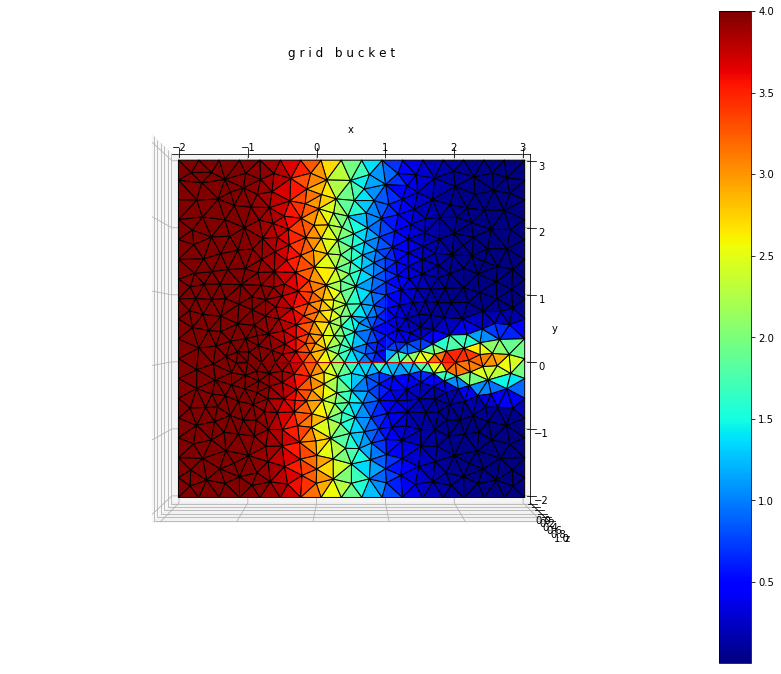

In [19]:
pp.plot_grid(gb, grid_variable, figsize=(15, 12))

cell_faces_T = g.cell_faces.T
def div(x):
    """
    Discrete divergence
    """
    return cell_faces_T * x

### Residual function
See `compressible_flow_with_automatic_differentiation`

def f(p, p0):
    # darcy:
    u = flux * p

    # Source:
    src = np.zeros(g.num_cells)
    src[60] = 1

    # Define residual function
    advection = div(avg(rho(p)) * u)
    lhs = advection
    rhs = src * g.cell_volumes

    return lhs - rhs